In [1]:
from typing import Union, List
import time
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt

### 1. Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

len(train_dataset), len(test_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [3]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

len(train_loader), len(test_loader)

(1563, 313)

### 2. Model

In [5]:
# Deep Feature Extraction
class DF_Extracion(nn.Module):
    def __init__(self, num_filters=64, kernel_size=3, device='cpu'):
        super().__init__()
        self.num_filters = num_filters
        self.device = device
        self.conv1 = nn.Conv2d(3, self.num_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        return x

class SimpleImageCLS(nn.Module):
    def __init__(self,
                 features: DF_Extracion,
                 img_size=32):
        super().__init__()
        self.features = features
        self.avgpool = nn.AvgPool2d((2, 2))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(1)
        in_features = int(self.features.num_filters*(img_size/2)**2)
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):
        x = self.features(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x


### 3. Evaluate

In [6]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            test_loss += loss.item()
            correct +=(predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

### 4. Train

In [7]:
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, device):
    since = time.perf_counter()
    history = {
        "train_losses": [],
        "train_accuracies": [],
        "test_losses": [],
        "test_accuracies": []
    }

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()

        epoch_loss =  running_loss / len(train_loader)
        epoch_accuracy = 100* running_correct / total
        test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        history['train_losses'].append(epoch_loss)
        history['train_accuracies'].append(epoch_accuracy)
        history['test_losses'].append(test_loss)
        history['test_accuracies'].append(test_accuracy)
    time_elapsed = time.perf_counter() - since
    print(f"Training complete in {time_elapsed//3600}h {time_elapsed%3600//60}m {int(time_elapsed%60)}s with {num_epochs} epochs")
    return history

In [8]:
device = 'cuda'
num_epochs = 100
LR = 0.001
criterion = nn.CrossEntropyLoss()

In [9]:
deep_features = DF_Extracion(num_filters=12, device=device)
deep_moddel = model = SimpleImageCLS(features=deep_features)
optimizer = torch.optim.Adam(deep_moddel.parameters(), lr=LR)
deep_history = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, device)

Epoch [1/100], Loss: 1.6513, Accuracy: 40.51%, Test Loss: 1.4823, Test Accuracy: 46.49%
Epoch [2/100], Loss: 1.3937, Accuracy: 49.83%, Test Loss: 1.3402, Test Accuracy: 51.29%
Epoch [3/100], Loss: 1.2861, Accuracy: 54.17%, Test Loss: 1.3442, Test Accuracy: 52.82%
Epoch [4/100], Loss: 1.2137, Accuracy: 56.93%, Test Loss: 1.2502, Test Accuracy: 54.86%
Epoch [5/100], Loss: 1.1597, Accuracy: 58.98%, Test Loss: 1.2032, Test Accuracy: 57.33%
Epoch [6/100], Loss: 1.1189, Accuracy: 60.50%, Test Loss: 1.2131, Test Accuracy: 56.69%
Epoch [7/100], Loss: 1.0828, Accuracy: 61.83%, Test Loss: 1.2039, Test Accuracy: 57.14%
Epoch [8/100], Loss: 1.0505, Accuracy: 63.13%, Test Loss: 1.2243, Test Accuracy: 57.41%
Epoch [9/100], Loss: 1.0200, Accuracy: 64.19%, Test Loss: 1.2061, Test Accuracy: 57.69%
Epoch [10/100], Loss: 0.9935, Accuracy: 65.12%, Test Loss: 1.1978, Test Accuracy: 58.21%
Epoch [11/100], Loss: 0.9711, Accuracy: 65.93%, Test Loss: 1.2024, Test Accuracy: 58.22%
Epoch [12/100], Loss: 0.9442, 

### 5. Plot the result

In [10]:
def plot_result(history):
    train_accuracies = history['train_accuracies']
    test_accuracies = history['test_accuracies']
    train_losses = history['train_losses']
    test_losses = history['test_losses']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),100])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Binary Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

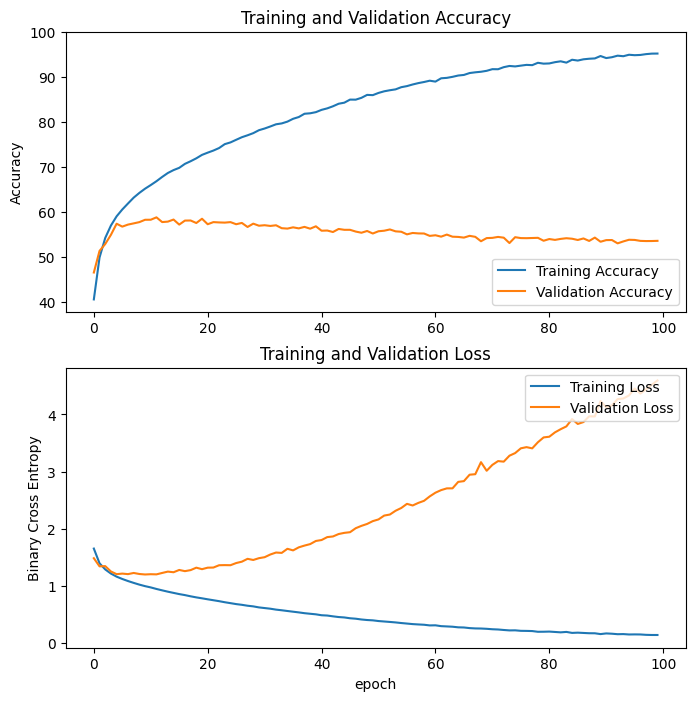

In [11]:
plot_result(deep_history) 